# Bank Failures Between 2000 and 2017

## Importing Packages

In [3]:
# %matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
import sklearn.linear_model as linear_model
import bokeh
import seaborn as sns
import math
import statistics
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter, LogColorMapper
from bokeh.palettes import Spectral5, Spectral6, Category20, Viridis256
from bokeh.palettes import Viridis6 as palette
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, show, output_file
from bokeh.models.ranges import FactorRange
from bokeh.core.properties import value
from bokeh.sampledata.us_states import data as statesData

## Loading and Transforming the Data

In [4]:
df = pd.read_csv('F:/Python/Final/banklist.csv', encoding='iso-8859-1')
df['Closing Date'] =  pd.to_datetime(df['Closing Date'], format='%d-%b-%y')
df['Updated Date'] =  pd.to_datetime(df['Updated Date'], format='%d-%b-%y')
df['Year'] = df['Closing Date'].astype(str).str[0:4]
df['Year'] = df['Year'].astype(int)
df['Acquired'] = (df['Acquiring Institution'] != "No Acquierer")

## Bank Failures Over Time

The following time series chart shows the number of bank failures over time. I have also included the median and mean as the recession data appears to be scewing the data. When we compare the number of failures per year to the median, it doesn't look like the number of bank failures is increasing over time. In fact, looking at a similar chart from FRED dating back to the 60s, our data does not look anomalous at all. Especially when economic climate is taken into account.

In [11]:
output_file("bank_failures_per_year.html")

source = pd.value_counts(df['Year'].values, sort=False)

plot = figure(title="Bank Failures Over Time", tools=['pan'])
plot.xaxis.axis_label = 'Year'
plot.yaxis.axis_label = 'Number of Bank Failures'

circle = plot.circle(source.index, source.values, fill_color="white", size=8)
line1 = plot.line(source.index, source.values, line_width=2, color='navy', legend='Number of Bank Failures')
line2 = plot.line(source.index, np.mean(source.values), line_width=2,  color='red', legend='Mean', line_dash='dashed')
line3 = plot.line(source.index, np.median(source.values), line_width=2,  color='green', legend='Median', line_dash='dotted')

hover1 = HoverTool(
    tooltips=[
        ( 'Year','$x{0}'),
        ( 'Bank Failures','@y{0}'),
    ], renderers=[circle],
)

hover2 = HoverTool(
    tooltips=[
        ( 'Mean','$y'),
    ], renderers=[line2],
)

hover3 = HoverTool(
    tooltips=[
        ( 'Median','$y'),
    ], renderers=[line3],
)
plot.add_tools(hover1)
plot.add_tools(hover2)
plot.add_tools(hover3)

plot.legend.location = "top_left"
show(plot)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='60279c47-ba50-4fdb-a29e-4cd3fcdf8913', ...)]


## Bank Acquisitions

The distribution of acquisitions for each institution is depicted below in a bar graph. Below that is my failed attempt to create a segmented bar chart. I anticipate that the acquired banks per institution would be highly concentrated in certain states, as some states had higher failure rates (as we will see later).

Text(0.5,1,'Number of Acquired Banks Per Institutions')

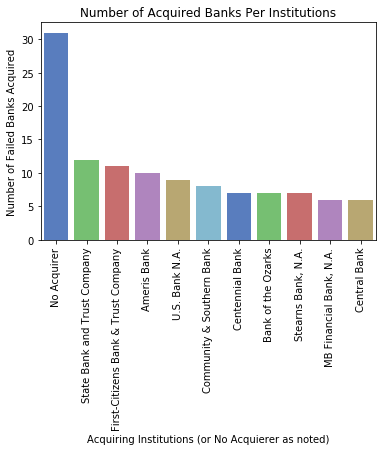

In [7]:
data = pd.value_counts(df['Acquiring Institution'].values, sort=True)[0:11]

x2 = []
for i in range(0, len(data)):
    x2.append(data.index[i])
y2 = []
for i in range(0, len(data)):
    y2.append(data.values[i])
bar = sns.barplot(x2, y2, data=None, palette="muted")
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
bar.set_xlabel('Acquiring Institutions (or No Acquierer as noted)')
bar.set_ylabel('Number of Failed Banks Acquired')
bar.set_title('Number of Acquired Banks Per Institution')

In [ ]:
df1 = pd.DataFrame(
    {'Acquiring Institution': x2,
     'NumberofAcquisitions': y2
    })


df2 = pd.DataFrame(df.groupby(['Acquiring Institution', 'ST'])['ST'].count()).rename(columns={'ST':'AcquisitionsbyState'})
df2 = df2.reset_index()

df2.merge(df1, how ='left', on='Acquiring Institution')
df2.columns = ['AcquiringInstitution', 'State','AcquisitionsbyState']


output_file("stacked.html")

p = figure(x_range=df2['AcquiringInstitution'], plot_height=250, title="Fruit Counts by Year",
           toolbar_location=None, tools="")

p.vbar_stack(State, x='AcquiringInstitution', width=0.9, color=colors, source=df2,
             legend=[value(x) for x in State])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

## Bank Failure and Month

The following chart is a pie graph of bank failures by the closure month. Standard banking quarters are January, February, and March (Q1); April, May, and June (Q2); July, August, and September (Q3); and October, November, and December (Q4). We can see clearly from the graph that instances of closure are more prevalent in the first month of every quarter (i.e. January, April, July, October).


In [12]:
output_file("colormapped_bars.html")

months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]
failures = [51, 44, 40, 59, 43, 36, 74, 41, 38, 59, 35, 35]
x_pos = [2] * 12
y_pos = [2] * 12
starts = [math.radians(i * 30) for i in range(12)]
ends = [x + math.radians(30) for x in starts]
max_fails = max(failures)
radii = [x / max_fails * 1.8 for x in failures]
colors = Category20[12]

TOOLS = "hover"



failure_source = ColumnDataSource(data=dict(months=months, failures=failures,
                                            x=x_pos, y=y_pos, radius=radii,
                                            start_angle=starts, end_angle=ends,
                                            color=colors))



p = figure(title="Bank Failures Per Month", plot_width=400, plot_height=400, x_range=(0, 4), y_range=(0, 4), tools = TOOLS)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Month", "@months"),
    ("Failures", "@failures")
]

p.wedge(x='x', y='y', radius='radius', start_angle='start_angle', end_angle='end_angle',
        color='color', source=failure_source)

p.title.text_font_size = "25px"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False

show(p)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='60279c47-ba50-4fdb-a29e-4cd3fcdf8913', ...)]


## Bank Failure By State

I began creating a choropleth map, but I had a lot of trouble with bokeh. I decided to switch to folium, but I was not able to install on my laptop. I moved on to the next graph. However, there is a trend with states. I do think that it might be more meaningful to also investigate percentage of banks in the state that failed, rather than just raw numbers (of percentage or failed banks that occured in a given state). 

In [9]:
data = pd.value_counts(df['ST'].values, sort=False)
data = data.reset_index()
data.columns = ['ST', 'COUNTS']

## Bank Failure By State Continued...

Instead I created a bar chart of the number of bank failures per state. There is a clear pattern of failure rate by state. This could be due to population size, regulation, number of existing banks, etc. The mean number of failed banks in a state is 7. However, a few states were considerably higher. I would want to look at the affect of the recession on the state (maybe change in median income from 2000-2017), number of banks per 100,000 people, change in population from 2000-2017, and regulation in the state. 

In [10]:
data = pd.value_counts(df['ST'].values, sort=True).reset_index()[0:23]
data.columns = ['State', 'Counts']

color=Viridis256

output_file("StateFailures.html")
p.xaxis.axis_label = 'State'
p.yaxis.axis_label = 'Number of Bank Failures'

p = figure(x_range=data['State'].values, plot_height=250, plot_width=400, title="Failures by State",
           tools=['pan'])


p.vbar(x=data['State'], top=data['Counts'], width=0.9, color='color')

hover = HoverTool(
    tooltips=[
        ( 'State','@x'),
    ('Number of Failures','@$Counts')]
)
p.add_tools(hover)
p.xaxis.major_label_orientation = 1.2


show(p)

print(data['Counts'].median())

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='60279c47-ba50-4fdb-a29e-4cd3fcdf8913', ...)]


11.0
